# Setup and install for test13

In [ ]:
%pip install gpflow
%pip install plotnine
%pip install plotly

In [ ]:
from plotnine import *
from plotnine.themes import *
import plotly as py
import plotly.graph_objs as go
import pandas as pd


In [ ]:
import tensorflow as tf
from scipy.io import loadmat
import random
import math
import tensorflow_probability as tfp

_paper_name_ establishes the reusable name of the paper, it represents the directory under data_papers on the google drive

In [ ]:
paper_name = "gpSVHN"

In [ ]:
import os, sys
import errno

# make a directory if it does not exist
def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')

# make directories if they do not exist

make_dir_if_not_exist("/content/drive/MyDrive/data_papers/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/gp_collab/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_predictions/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/model_ccs/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/")
make_dir_if_not_exist(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/temp/")


This will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

[Here](https://github.com/aditya9211/SVHN-CNN/blob/master/svhn_model.ipynb) is a github project that uses the same data.



In [ ]:
data_location = '/content/drive/MyDrive/mlpapers/GP_Collab_SVHN'

In [ ]:
# Run this cell to load the dataset
train = loadmat(f'{data_location}/train_32x32.mat')
test = loadmat(f'{data_location}/test_32x32.mat')
extra = loadmat(f'{data_location}/extra_32x32.mat')

In [ ]:
# we have  png files with house numbers for the extra as well, in case of other ideas
# https://stackoverflow.com/questions/15612373/convert-image-png-to-matrix-and-then-to-1d-array

In [ ]:
# Set up the imports
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Concatenate, Add, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np

import site
import os
import tensorflow as tf
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import errno
import numpy as np
import itertools
import multiprocessing
import json
import datetime
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import  Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise, AveragePooling2D
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, SimpleRNN, GRU, LeakyReLU, Add
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.summary import create_file_writer

pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


## Inspect and Preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* turn test into validation and slice some extra for test
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel.
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.
# Why greyscale?
* So we get worse performance and have less discriminating features, allowing us to discern the impact of the GP on the features in _collaborative_ learning better.


In [ ]:
train_data = train['X']
validation_data = test['X']
test_data = extra['X'][:,:,:,:30000]
train_targets = train['y']
validation_targets = test['y']
test_targets = extra['y'][:30000]

In [ ]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
            
        ax.imshow(images[:,:,:,i])
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images(train_data[:,:,:,idxs],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[4109, 6439, 16792, 20368, 25196, 47299, 52152, 53332, 64275, 68022]


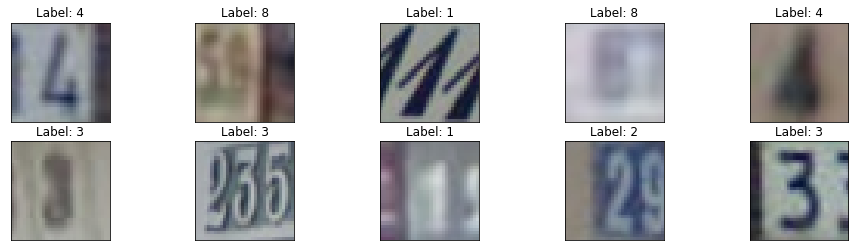

In [ ]:
plot_sample(10)

Convert the train, test and validation data to greyscale

In [ ]:
train_data_grey = train_data.mean(axis=2)
train_data_grey = np.expand_dims(train_data_grey,axis=2)
train_data_grey = np.moveaxis(train_data_grey, 3, 0)

test_data_grey = test_data.mean(axis=2)
test_data_grey = np.expand_dims(test_data_grey,axis=2)
test_data_grey = np.moveaxis(test_data_grey, 3, 0)

validation_data_grey = validation_data.mean(axis=2)
validation_data_grey = np.expand_dims(validation_data_grey,axis=2)
validation_data_grey = np.moveaxis(validation_data_grey, 3, 0)

print(train_data.shape)
print(train_data_grey.shape)

(32, 32, 3, 73257)
(73257, 32, 32, 1)


Set the 10th class to zero (represents '0' digit)

In [ ]:
train_targets[train_targets == 10] = 0
validation_targets[validation_targets == 10] = 0
test_targets[test_targets == 10] = 0

In [ ]:
def plot_images_grey(images, nrows, ncols, cls_true):
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        title = "Label: {0}".format(true_number)
        ax.imshow(images[i,:,:,0],cmap='gray', vmin=0, vmax=255)
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

def plot_sample_grey(num_sample=10):
    idxs = sorted(random.sample(range(train_targets.shape[0]),num_sample))
    plot_images_grey(train_data_grey[idxs,:,:,:],2,math.ceil(num_sample/2),train_targets[idxs])    
    print(idxs)


[2357, 2658, 8021, 11809, 31776, 44212, 46195, 46351, 61226, 66349]


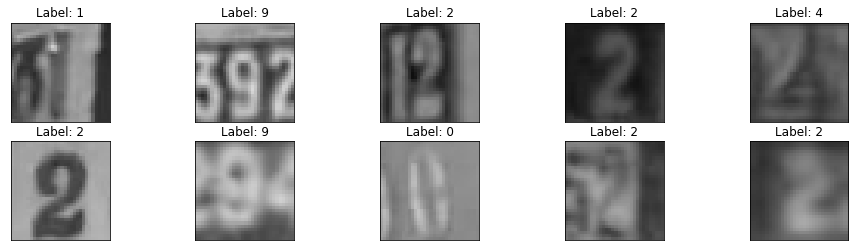

In [ ]:
plot_sample_grey(10)

In [ ]:
# extracts the layer from a model using the name
def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


In [ ]:
# plotting utilities for the history of the fit
def plot_history(history):
    acc_keys = [k for k in history.history.keys() if 'accuracy' in k]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

def plot_history_df(history):
    acc_keys = [k for k in history.columns.values if 'accuracy' in k]
    loss_keys = [k for k in history.columns.values if not k in acc_keys and not k in ['epoch']]
    for k, v in history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        if k in loss_keys:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()   


A function that will take a model construction function (with _model_name_ and _input_shape_ arguments), train and fit it using the supplied data and callbacks. The _kwargs_ are supplied to the model fit function.

In [ ]:
from tensorflow.keras.callbacks import CSVLogger
import datetime

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  early_stopping_obs = 'val_sparse_categorical_accuracy',
                                  log_history = True,
                                  verbose_level = 0,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
      
    if 'validation_data' not in kwargs.keys() and 'val_' in early_stopping_obs:
        early_stopping_obs = early_stopping_obs.replace('val_','')

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'/content/drive/MyDrive/data_papers/{paper_name}/model_checkpoints/{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor = early_stopping_obs,
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(monitor=early_stopping_obs, patience=patience_count))

    if log_history:
        callbacks_used.append(tf.keras.callbacks.CSVLogger(f"/content/drive/MyDrive/data_papers/{paper_name}/model_history/history_log_{model_name}_{datetime.date.today().strftime('%Y%m%d')}.csv", append=True))

    m.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=verbose_level, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

A function that given a model or model directory create a new model up to the _layer_name_, then write the features matching the supplied _X_ and _Y_ as numpy arrays to google drive.

In [ ]:
def write_features_from_models(
        model_entry,
        layer_name,
        X_input, Y_input,
        reverse_one_hot=False,
        normalize_X_func=None,
        dataset_id = "NA",
        **kwargs):
  
    Y_new = None
    X_new = None
    if reverse_one_hot:
        Y_new = np.apply_along_axis(np.argmax, 1, Y_input) + 1
    else:
        Y_new = Y_input.copy()

    model_here = None
    if isinstance(model_entry, tf.keras.models.Model):
        model_here = model_entry
        model_file_name = model_here.name
    else:
        model_here = tf.keras.models.load_model(model_entry,**kwargs) 

    features_model = Model(model_here.input,
                            get_layer_by_name(model_here.layers, layer_name).output)
    if normalize_X_func is None:
        X_new = np.array(features_model.predict(X_input), dtype='float64')
    else:
        X_new = np.array(normalize_X_func(features_model.predict(X_input)), dtype='float64')

    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_X", X_new, 
               allow_pickle=True, 
               fix_imports=True)
    np.save(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{model_here.name}_features_{layer_name}_{dataset_id}_Y", Y_new, 
               allow_pickle=True, 
               fix_imports=True)

Some functions to get scores on the results

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import re

def get_confusion_matrix_classification(model, X, Y_true):
    y_pred = model.predict(X)
    y_true = np.apply_along_axis(np.argmax, 1, Y_true)
    y_pred = np.apply_along_axis(np.argmax, 1, y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def construct_confusion_matrix(X, Y_true, Y_pred):
    y_true = Y_true
    y_pred = np.apply_along_axis(np.argmax, 1, Y_pred)
    return (confusion_matrix(y_true, y_pred), y_pred, y_true)

def pr_rc_f1_acc_from_supplied(y_pred, y_true):  
    pr, rc, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")   
    acc = accuracy_score(y_true, y_pred)
    return pr, rc, f1, acc


In [ ]:
import re
import os

def dir_has_file_with_regex(dir_name, regex_string):
  filenames = [ f"{dir_name}/{dir_entry.name}" for dir_entry in os.scandir(dir_name) if os.path.isfile(f"{dir_name}/{dir_entry.name}") ]   
  filenames = [ fn for fn in filenames if re.match(regex_string, fn, re.IGNORECASE) ]
  return filenames



In [ ]:
# dir_has_file_with_regex("/content/drive/MyDrive/data_papers/gpSVHN/model_features", "^.*DNN_A_.*D3R_Test_X.*")

# A basic model functions

In [ ]:
def basic_DNNTemplate_A(model_name, inshape, num_classes = 10):

  base_input = Input(shape=inshape, name='base_input')
  f1_output = Flatten(name='F1')(base_input)
  d1_output = Dense(128, activation='relu', name = 'D1')(f1_output)
  d2_output = Dense(128, activation='relu', name = 'D2')(d1_output)
  d3r_output = Dense(48, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.005), name = 'D3R')(d2_output)
  model_output = Dense(10,  activation='softmax', name = 'SFTMX1')(d3r_output)
  model = Model(base_input, model_output, name = model_name)

  return model

In [ ]:
def basic_CNNTemplate_A(model_name, inshape, num_classes = 10):
  # Input Layer
  base_input = Input(shape=inshape, name='base_input')
  # Convolutional Layer #1
  c1_output = Conv2D(filters=32,kernel_size=[5, 5],padding="same",activation="relu", name="C1")(base_input)

  # Pooling Layer #1
  mxp1_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP1")(c1_output)
  c2_output = Conv2D(filters=64,kernel_size=[5, 5],padding="same",activation="relu",name="C2")(mxp1_output)
    
  #with tf.name_scope('Pool2 Layer'):
  mxp2_output = MaxPooling2D(pool_size=[2, 2], strides=2, name="MXP2")(c2_output)
  f1_output = Flatten(name='F1')(mxp2_output)

  # Dense Layer
  d1_output = Dense(units=256, activation="relu", name="D1")(f1_output)
  drp1_output = Dropout(rate=0.5, name="DRP1")(d1_output)

  model_output = Dense(num_classes,  activation='softmax', name = 'SFTMX1')(drp1_output)
  model = Model(base_input, model_output, name = model_name)
  return model

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization


In [ ]:
def basic_ResNet50Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(ResNet50(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)

def basic_VGG19Template_A(model_name, inshape, num_classes = 10):
  model = Sequential(name=model_name)
  model.add(VGG19(include_top=True, pooling='avg', weights=None,input_shape=inshape, classes=num_classes))
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',      
                metrics=['acc'])
  return(model)



In [ ]:
import uuid
# uuid.uuid4()
# str(uuid.uuid4()).split("-")[0]

In [ ]:
# https://github.com/asmith26/wide_resnets_keras

# Wide residual network http://arxiv.org/abs/1605.07146
def _wide_basic(n_input_plane, n_output_plane, stride, identifier, 
                channel_axis = -1,
                weight_decay = 0.0005,
                weight_init="he_normal",
                use_bias = False,
                dropout_probability = 0.0
                ):
    def f(net):
        # format of conv_params:
        #               [ [nb_col="kernel width", nb_row="kernel height",
        #               subsample="(stride_vertical,stride_horizontal)",
        #               border_mode="same" or "valid"] ]
        # B(3,3): orignal <<basic>> block
        conv_params = [ [3,3,stride,"same"],
                        [3,3,(1,1),"same"] ]
        
        n_bottleneck_plane = n_output_plane

        # Residual block
        for i, v in enumerate(conv_params):
            if i == 0:
                if n_input_plane != n_output_plane:
                    net = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    net = Activation("relu")(net)
                    convs = net
                else:
                    convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(net)
                    convs = Activation("relu")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name = f"CONV0_{identifier}_{uuid.uuid4()}")(convs)
            else:
                convs = BatchNormalization(axis=channel_axis, name=f"BN{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Activation("relu")(convs)
                if dropout_probability > 0:
                   convs = Dropout(dropout_probability, name=f"DRP{str(i)}_{identifier}_{uuid.uuid4()}")(convs)
                convs = Conv2D(n_bottleneck_plane, 
                               (v[0],v[1]),
                                strides=v[2],
                                padding=v[3],
                                kernel_initializer=weight_init,
                                kernel_regularizer=L2(weight_decay),
                                use_bias=use_bias,
                                name=f"CONV{str(i)}_{identifier}_{uuid.uuid4()}")(convs)

        # Shortcut Conntection: identity function or 1x1 convolutional
        #  (depends on difference between input & output shape - this
        #   corresponds to whether we are using the first block in each
        #   group; see _layer() ).
        if n_input_plane != n_output_plane:
            shortcut = Conv2D(n_output_plane, 
                              (1,1),
                              strides=stride,
                              padding="same",
                              kernel_initializer=weight_init,
                              kernel_regularizer=L2(weight_decay),
                              use_bias=use_bias,
                              name=f"CONVSHORTCUT_{identifier}_{uuid.uuid4()}")(net)
        else:
            shortcut = net

        return Add()([convs, shortcut])
    
    return f


# "Stacking Residual Units on the same stage"
def _layer(block, n_input_plane, n_output_plane, count, stride):
    def f(net):
        net = block(n_input_plane, n_output_plane, stride)(net)
        for i in range(2,int(count+1)):
            net = block(n_output_plane, n_output_plane, stride=(1,1))(net)
        return net
    
    return f


# Set up the models + features file lists for CNN/DNN/ResNet50/WideResNet28-10 splits for reuse SVHN

In [ ]:
acceptable_string_grabs = [ "CNN_A_", "DNN_A_", "RestNet50_A_", "WideResNet28-10_ID"]
not_check_model_string = ["arallel","Collab_"]

model_dirs = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/{dir_entry.name}" 
                for dir_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_finals/") 
                if os.path.isdir(dir_entry) and any(xs in dir_entry.name for xs in acceptable_string_grabs) ]
dnn_model_dirs = [ s for s in model_dirs if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_model_dirs = [ s for s in model_dirs if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_model_dirs = [ s for s in model_dirs if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_model_dirs = [ s for s in model_dirs if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

model_features_files = [  f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/{file_entry.name}" 
                for file_entry in os.scandir(f"/content/drive/MyDrive/data_papers/{paper_name}/model_features/") 
                if os.path.isfile(file_entry) and any(xs in file_entry.name for xs in acceptable_string_grabs) ]

dnn_features_files = [ s for s in model_features_files if "DNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
cnn_features_files = [ s for s in model_features_files if "CNN" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
resnets_features_files = [ s for s in model_features_files if "RestNet50" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 
wideresnets_features_files = [ s for s in model_features_files if "WideResNet" in s and all([ (not ncs in s) for ncs in not_check_model_string])] 

dnn_identifier = acceptable_string_grabs[1]
# dnn_layer_name = "DRP1"

cnn_identifier = acceptable_string_grabs[0]
# cnn_layer_name = "D3R"

wideresnet_identifier = acceptable_string_grabs[3]
# wideresnet_layer_name = "CLASSIFIER_FL"


def avgfilter_ensemble_predictions(y_pred_ms, xtest):
  y_preds_ens_prb = np.apply_along_axis(np.mean, 0, y_pred_ms)
  y_preds_ens_idx = np.apply_along_axis(np.argmax, 1, y_preds_ens_prb) 
  # y_preds_ens_idx = y_preds_ens_idx + 1
  return y_preds_ens_idx  




# Set up data and functions




In [ ]:
import pandas as pd

def get_validation_acc_from_history_file(f1):
  pd1 = pd.read_csv(f1)
  return pd1[pd1.epoch==max(pd1.epoch)].val_sparse_categorical_accuracy.iloc[0]


In [ ]:
# get validation and test accuracies
val_accs = pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/val_test_accs_20211118165251.csv")
best_submodels = val_accs.loc[val_accs.groupby("Type")['ValAcc'].idxmax()].copy()

In [ ]:
# get collab data from last dense
all_lastdense_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_lastdense_test_results" in f ])
all_lastdense_collab_data = all_lastdense_collab_data.drop_duplicates()
all_lastdense_collab_data["BestComponent"] = np.nan
for typename in best_submodels["Type"]:
  all_lastdense_collab_data.loc[all_lastdense_collab_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_lastdense_collab_data["Layer"] = "LastDense"
all_lastdense_collab_data["Xtra"] = "Random"

# get collab data from softmax
all_sftmx_collab_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_test_results" in f ])
all_sftmx_collab_data = all_sftmx_collab_data.drop_duplicates()
all_sftmx_collab_data["BestComponent"] = np.nan
for typename in best_submodels["Type"]:
  all_sftmx_collab_data.loc[all_sftmx_collab_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_sftmx_collab_data["Layer"] = "Softmax"
all_sftmx_collab_data["Xtra"] = "Random"

# get ensemble data
all_ensemble_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if "ensemble" in f and ".csv" in f and "contour" not in f])
all_ensemble_data = all_ensemble_data.drop_duplicates() 
all_ensemble_data = all_ensemble_data[["Type","Data", "NumOfModels",	"RepC"	,"Pr", "Rc",	"F1" , "Acc"]]
all_ensemble_data["BestComponent"] = np.nan
for typename in best_submodels["Type"]:
  all_ensemble_data.loc[all_ensemble_data.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_ensemble_data["Layer"] = "Ensemble"
all_ensemble_data["Xtra"] = "Random"


In [ ]:
# get collab using CCA on softmax
all_sftmx_collab_cca = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "collab_ccaorder_sftmx_test_results" in f ])
all_sftmx_collab_cca = all_sftmx_collab_cca.drop_duplicates()
all_sftmx_collab_cca["BestComponent"] = np.nan
for typename in best_submodels["Type"]:
  all_sftmx_collab_cca.loc[all_sftmx_collab_cca.Type==typename,"BestComponent"] = float(best_submodels.loc[best_submodels.Type==typename, "TestAcc"])
all_sftmx_collab_cca["Layer"] = "Softmax"



In [ ]:
all_sftmx_collab_data = pd.concat([all_sftmx_collab_data,all_sftmx_collab_cca], ignore_index=True)
all_sftmx_collab_data.loc[all_sftmx_collab_data.Xtra!="CCAmin","Xtra"] = "Random"

In [ ]:
# print(len(all_sftmx_collab_data.index),len(all_lastdense_collab_data.index))
test_acc_data = pd.concat([all_lastdense_collab_data.reset_index(drop=True), all_sftmx_collab_data.reset_index(drop=True), all_ensemble_data.reset_index(drop=True)])


In [ ]:
# test_acc_data[test_acc_data.Xtra=="Ensemble"]
all_ensemble_data

,Type,Data,NumOfModels,RepC,Pr,Rc,F1,Acc,BestComponent,Layer,Xtra
0,DNN,Test,5,0.0,0.898648,0.898133,0.897951,0.898133,0.874700,Ensemble,Random
1,DNN,Test,5,1.0,0.900499,0.900233,0.899906,0.900233,0.874700,Ensemble,Random
2,DNN,Test,5,2.0,0.900577,0.900600,0.900393,0.900600,0.874700,Ensemble,Random
3,DNN,Test,5,3.0,0.895359,0.895000,0.894845,0.895000,0.874700,Ensemble,Random
4,DNN,Test,5,4.0,0.893037,0.893233,0.892991,0.893233,0.874700,Ensemble,Random
...,...,...,...,...,...,...,...,...,...,...,...
61,CNN,Test,22,2.0,0.966539,0.966367,0.966348,0.966367,0.946867,Ensemble,Random
62,CNN,Test,22,3.0,0.966225,0.966033,0.966016,0.966033,0.946867,Ensemble,Random
63,CNN,Test,25,0.0,0.966596,0.966433,0.966414,0.966433,0.946867,Ensemble,Random
64,CNN,Test,25,1.0,0.966742,0.966533,0.966529,0.966533,0.946867,Ensemble,Random


In [ ]:
sftmx_contour_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in  os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "cnn_dnn_contour_data" in f ])
sftmx_contour_data = sftmx_contour_data.drop_duplicates()
sftmx_contour_data["NumOfModels"] = sftmx_contour_data.NumOfA + sftmx_contour_data.NumOfB
sftmx_contour_data["Type"] = "CNN_DNN"
sftmx_contour_data["CNN%"] = sftmx_contour_data.NumOfA/sftmx_contour_data["NumOfModels"]

In [ ]:
sftmx_cwcontour_data = pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}") for f in  os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/") if "cnn_wideresnet_contour_data" in f ])
sftmx_cwcontour_data = sftmx_cwcontour_data.drop_duplicates()
sftmx_cwcontour_data["NumOfModels"] = sftmx_cwcontour_data.NumOfA + sftmx_cwcontour_data.NumOfB
sftmx_cwcontour_data["Type"] = "CNN_WRN"
sftmx_cwcontour_data["WR%"] = sftmx_cwcontour_data.NumOfB/sftmx_cwcontour_data["NumOfModels"]

In [ ]:
# get all contour data
all_contour_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if ".csv" in f and "contour" in f])
all_contour_data = all_contour_data.drop_duplicates() 
all_contour_data.loc[all_contour_data.Layer!="Ensemble","Layer"] = "Softmax"


In [ ]:
# test_acc_data.loc[max(test_acc_data.index)]["Pr"]

In [ ]:
all_acc_data = pd.concat([test_acc_data.groupby(["Type","NumOfModels","Layer","Xtra"])["Acc"].mean(), test_acc_data.groupby(["Type","NumOfModels","Layer","Xtra"])["BestComponent"].mean()],axis=1)
all_acc_data = all_acc_data.reset_index()
all_acc_data = all_acc_data[all_acc_data.NumOfModels>1]


In [ ]:
all_acc_data

,Type,NumOfModels,Layer,Xtra,Acc,BestComponent
1,CNN,2,Ensemble,Random,0.953356,0.946867
2,CNN,2,LastDense,Random,0.953808,0.946867
3,CNN,2,Softmax,CCAmin,0.948167,0.946867
4,CNN,2,Softmax,Random,0.948842,0.946867
5,CNN,3,Ensemble,Random,0.957277,0.946867
...,...,...,...,...,...,...
167,WideResNet,8,Softmax,Random,0.982833,0.966500
168,WideResNet,9,Ensemble,Random,0.983030,0.966500
169,WideResNet,9,Softmax,Random,0.983375,0.966500
170,WideResNet,10,Ensemble,Random,0.983233,0.966500


In [ ]:
# get the WideResNet gp data
all_gp_data =  pd.concat([ pd.read_csv(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results/{f}").reset_index(drop=True) for f in os.listdir(f"/content/drive/MyDrive/data_papers/{paper_name}/summary_results") if ".csv" in f and "Collab_gp_" in f and "WideResNet" in f])
all_gp_data = all_gp_data.drop_duplicates() 
all_gp_data = all_gp_data[all_gp_data.GPName == "matern12"]
all_gp_data.reset_index(inplace=True)
all_gp_data = all_gp_data[["Type","Data","NumOfModels","GPName","Pr","Rc","F1","Acc"]]
# all_contour_data.loc[all_contour_data.Layer!="Ensemble","Layer"] = "Softmax"
all_gp_data = all_gp_data.rename(columns={"GPName":"Xtra"})
all_gp_data["Type"] = "WideResNet"  # leftover bug
all_gp_data["Layer"] = "Softmax"

In [ ]:
all_acc_data = pd.concat([all_acc_data,all_gp_data], ignore_index=True)
all_acc_data_2 = pd.melt(all_acc_data, id_vars=['Type','NumOfModels','Layer','Xtra'], value_name="Acc", var_name="AccType")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning:

This dataframe has a column name that matches the 'value_name' column name of the resultiing Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.



In [ ]:
all_gp_data

,Type,Data,NumOfModels,Xtra,Pr,Rc,F1,Acc,Layer
0,WideResNet,Test,2,matern12,0.976060,0.976033,0.976036,0.976033,Softmax
1,WideResNet,Test,3,matern12,0.976846,0.976833,0.976833,0.976833,Softmax
2,WideResNet,Test,4,matern12,0.977334,0.977300,0.977303,0.977300,Softmax
3,WideResNet,Test,5,matern12,0.981453,0.981433,0.981437,0.981433,Softmax
4,WideResNet,Test,6,matern12,0.982747,0.982733,0.982736,0.982733,Softmax
5,WideResNet,Test,7,matern12,0.982158,0.982133,0.982137,0.982133,Softmax
6,WideResNet,Test,8,matern12,0.983184,0.983167,0.983169,0.983167,Softmax
7,WideResNet,Test,9,matern12,0.982844,0.982833,0.982834,0.982833,Softmax
8,WideResNet,Test,10,matern12,0.983578,0.983567,0.983568,0.983567,Softmax
9,WideResNet,Test,11,matern12,0.983546,0.983533,0.983534,0.983533,Softmax


# Plots of number of models by model type and ensemble/collab with layer information




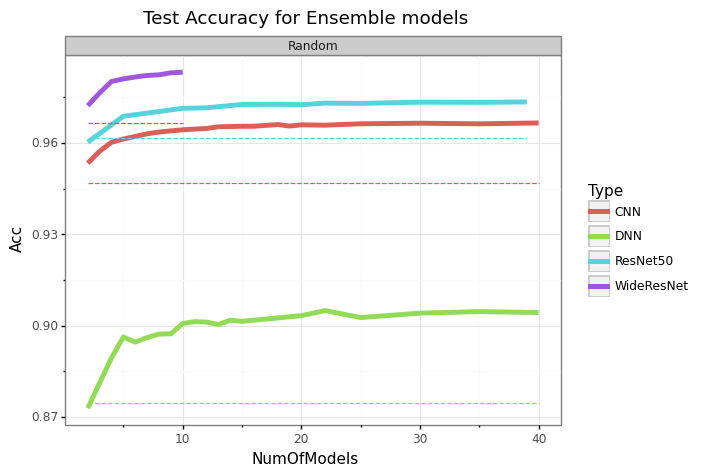

<ggplot: (8729519040229)>

In [ ]:
ggplot(all_acc_data[all_acc_data.Layer=="Ensemble"]) +  \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) +  \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed')  + theme_bw() + ggtitle('Test Accuracy for Ensemble models') + facet_grid('.~Xtra')

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



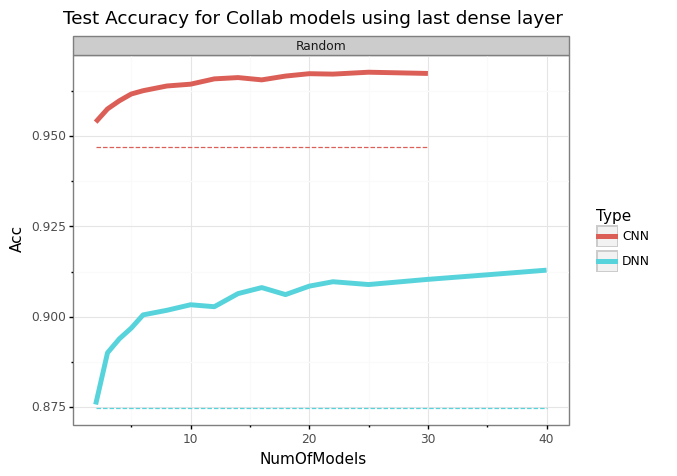

<ggplot: (8729517668873)>

In [ ]:
ggplot(all_acc_data[all_acc_data.Layer=="LastDense"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed')  + theme_bw() + ggtitle('Test Accuracy for Collab models using last dense layer') + facet_grid('.~Xtra')

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning:

geom_path: Removed 11 rows containing missing values.



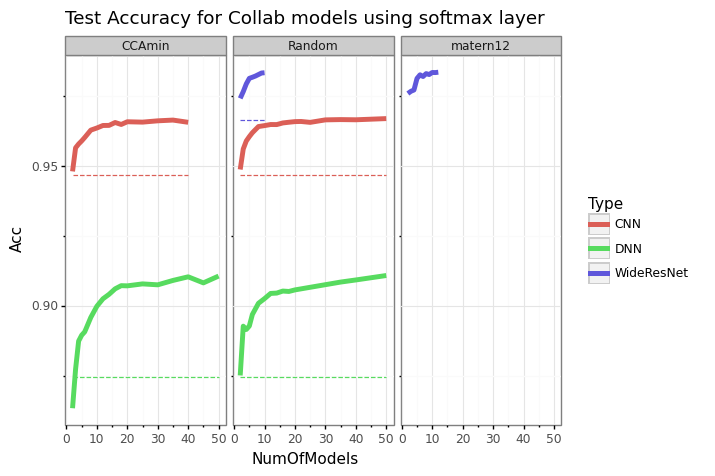

<ggplot: (8729508689689)>

In [ ]:
ggplot(all_acc_data[all_acc_data.Layer=="Softmax"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed')  + theme_bw() + ggtitle('Test Accuracy for Collab models using softmax layer') + facet_grid('.~Xtra')

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



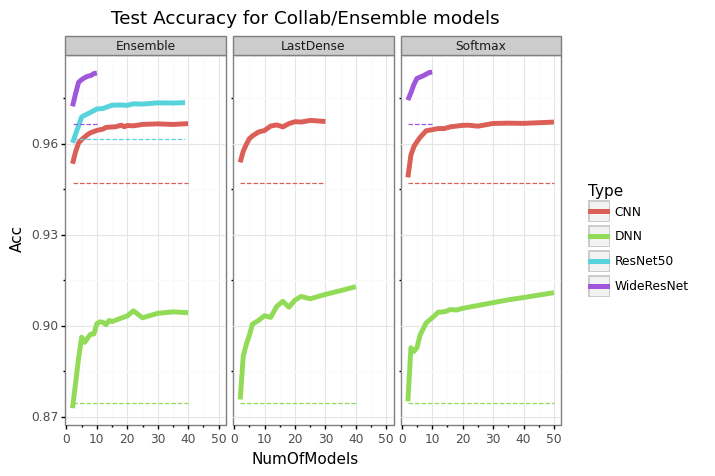

<ggplot: (8729508724921)>

In [ ]:
ggplot(all_acc_data[all_acc_data.Xtra=="Random"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Type',color='Type', fill='Type'),size=2) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Type',color='Type', fill='Type'), linetype='dashed') + facet_grid('.~Layer') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models')

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



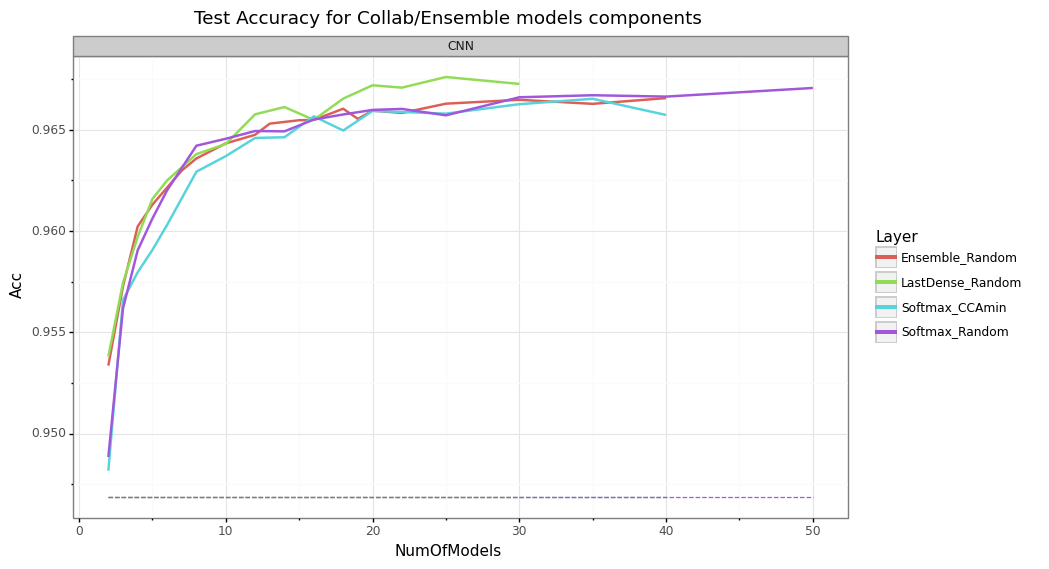

<ggplot: (8729508391929)>

In [ ]:
cnn_data = all_acc_data[all_acc_data.Type=="CNN"].copy()
cnn_data['Layer'] = cnn_data[['Layer', 'Xtra']].agg('_'.join, axis=1)

ggplot(cnn_data) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Layer',color='Layer', fill='Layer'),size=1) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Layer',color='Layer', fill='Layer'), linetype='dashed') + facet_grid('.~Type') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models components') + theme(figure_size = (10, 6))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



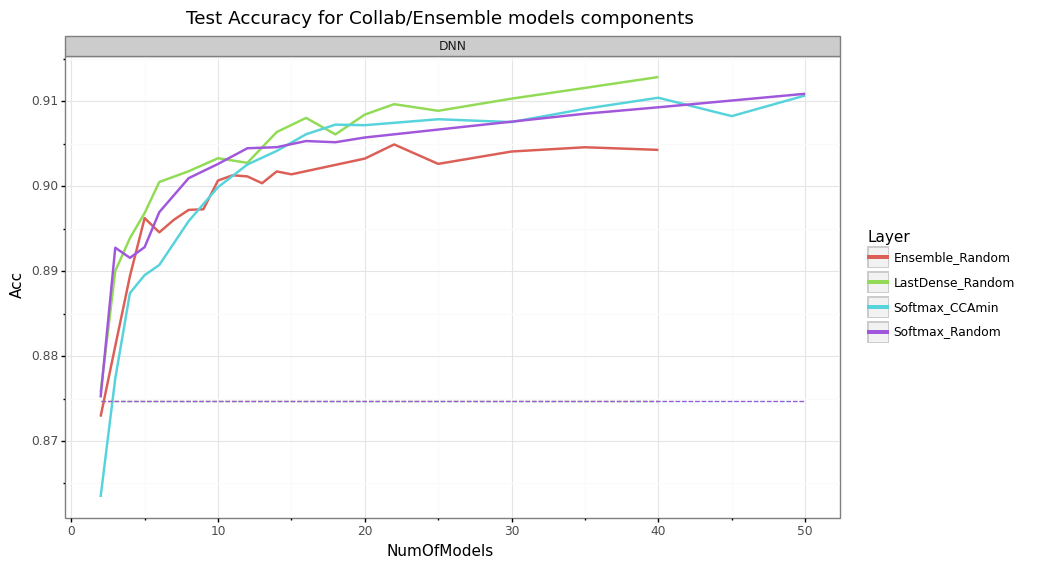

<ggplot: (8729508370977)>

In [ ]:
dnn_data = all_acc_data[all_acc_data.Type=="DNN"].copy()
dnn_data['Layer'] = dnn_data[['Layer', 'Xtra']].agg('_'.join, axis=1)

ggplot(dnn_data) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Layer',color='Layer', fill='Layer'),size=1) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Layer',color='Layer', fill='Layer'), linetype='dashed') + facet_grid('.~Type') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models components') + theme(figure_size = (10, 6))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning:

geom_path: Removed 11 rows containing missing values.



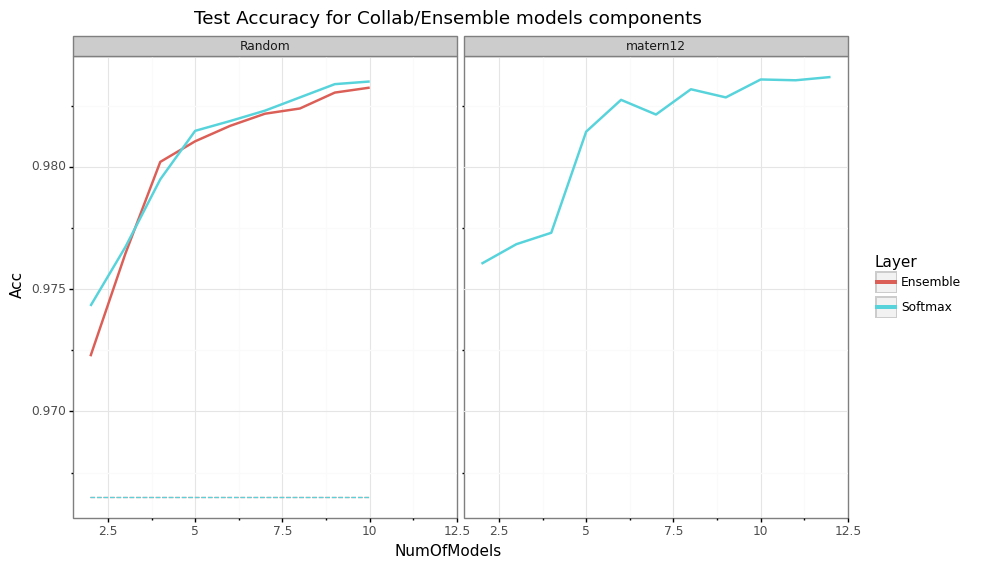

<ggplot: (8729508369933)>

In [ ]:
ggplot(all_acc_data[all_acc_data.Type=="WideResNet"]) + \
geom_line(aes(x='NumOfModels',y='Acc',group='Layer',color='Layer', fill='Layer'),size=1) + \
geom_line(aes(x='NumOfModels',y='BestComponent',group='Layer',color='Layer', fill='Layer'), linetype='dashed') + facet_grid('.~Xtra') + theme_bw() + ggtitle('Test Accuracy for Collab/Ensemble models components') + theme(figure_size = (10, 6))


# Contour Plots of number of models by model type and ensemble/collab with layer information




## Contour Plots for ensemble CNN+WideResNet




In [ ]:
cnn_wrn_contour = all_contour_data.loc[(all_contour_data.Layer=="Ensemble") & (all_contour_data.TypeA=="CNN") & (all_contour_data.TypeB=="WideResNet")].copy()
cnn_wrn_contour = cnn_wrn_contour.drop_duplicates()
cnn_wrn_contour["NumOfModels"] = cnn_wrn_contour.NumOfA + cnn_wrn_contour.NumOfB
cnn_wrn_contour["Type"] = "CNN_WRN"
cnn_wrn_contour["WR%"] = cnn_wrn_contour.NumOfB/cnn_wrn_contour["NumOfModels"]

In [ ]:
cnn_wrn_contour

,Unnamed: 0,TypeA,TypeB,Data,NumOfA,NumOfB,RepC,Pr,Rc,F1,Acc,Layer,NumOfModels,Type,WR%
0,0,CNN,WideResNet,Test,2,0,0,0.954184,0.954067,0.954022,0.954067,Ensemble,2,CNN_WRN,0.000000
1,1,CNN,WideResNet,Test,2,0,0,0.953110,0.952933,0.952905,0.952933,Ensemble,2,CNN_WRN,0.000000
2,2,CNN,WideResNet,Test,1,1,0,0.965887,0.965667,0.965657,0.965667,Ensemble,2,CNN_WRN,0.500000
3,3,CNN,WideResNet,Test,0,2,0,0.972949,0.972667,0.972665,0.972667,Ensemble,2,CNN_WRN,1.000000
4,4,CNN,WideResNet,Test,2,0,1,0.954158,0.954100,0.954045,0.954100,Ensemble,2,CNN_WRN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
876,876,CNN,WideResNet,Test,4,8,9,0.981634,0.981567,0.981571,0.981567,Ensemble,12,CNN_WRN,0.666667
877,877,CNN,WideResNet,Test,3,9,9,0.983190,0.983133,0.983138,0.983133,Ensemble,12,CNN_WRN,0.750000
878,878,CNN,WideResNet,Test,2,10,9,0.983845,0.983800,0.983801,0.983800,Ensemble,12,CNN_WRN,0.833333
879,879,CNN,WideResNet,Test,1,11,9,0.983554,0.983500,0.983502,0.983500,Ensemble,12,CNN_WRN,0.916667


In [ ]:
cnn_wrn_contour_core = cnn_wrn_contour[["NumOfModels","WR%","Acc"]].copy()
cnn_wrn_contour_core["NumOfModels"] = cnn_wrn_contour_core["NumOfModels"].astype(float)

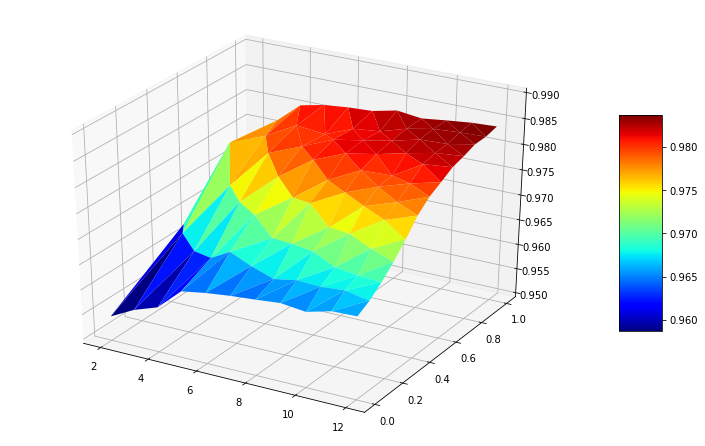

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(cnn_wrn_contour_core["NumOfModels"], cnn_wrn_contour_core["WR%"], cnn_wrn_contour_core["Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.95, 0.99)

plt.show()


In [ ]:
fig = go.Figure(data =
    go.Contour(
        z=cnn_wrn_contour_core.Acc,
        x=cnn_wrn_contour_core["NumOfModels"], # horizontal axis
        y=cnn_wrn_contour_core["WR%"], # vertical axis
    colorscale='RdBu',
    contours=dict(
            start=0.95,
            end=0.99,
            size=0.002,
        )))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(        l=50,        r=50,        b=100,        t=100,        pad=4    ),
    paper_bgcolor="White",
   title="Ensemble Test Accuracy using CNN+WideResNet ",
    xaxis_title="Total Number of Models",
    yaxis_title="% of WideResNet models"
)

fig.show()


## Contour Plots for collaborative CNN+WideResNet on the softmax layer




In [ ]:
sftmx_cwcontour_core = sftmx_cwcontour_data[["NumOfModels","WR%","Acc"]].copy()
sftmx_cwcontour_core["NumOfModels"] = sftmx_cwcontour_core["NumOfModels"].astype(float)

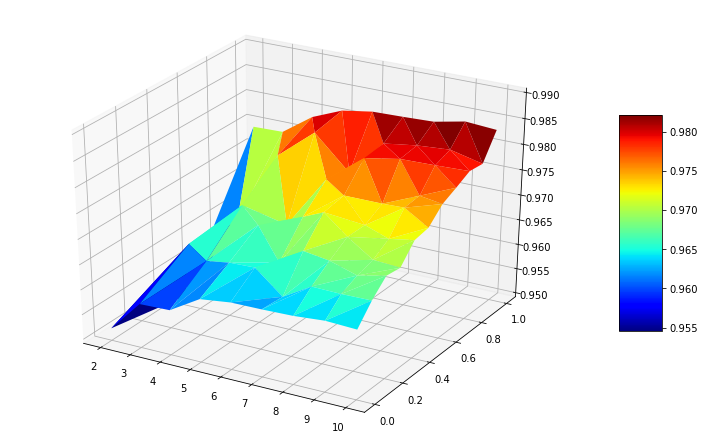

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(sftmx_cwcontour_core["NumOfModels"], sftmx_cwcontour_core["WR%"], sftmx_cwcontour_core["Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.95, 0.99)

plt.show()


In [ ]:
fig = go.Figure(data =
    go.Contour(
        z=sftmx_cwcontour_core.Acc,
        x=sftmx_cwcontour_core["NumOfModels"], # horizontal axis
        y=sftmx_cwcontour_core["WR%"], # vertical axis
    colorscale='RdBu',
    contours=dict(
            start=0.95,
            end=0.99,
            size=0.002,
        )))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(        l=50,        r=50,        b=100,        t=100,        pad=4    ),
    paper_bgcolor="White",
   title="Softmax Collaborative Test Accuracy using CNN+WideResNet ",
    xaxis_title="Total Number of Models",
    yaxis_title="% of WideResNet models"
)

fig.show()


## Contour Plots for collaborative CNN+DNN on the softmax layer




In [ ]:
sftmx_contour_core = sftmx_contour_data[["NumOfModels","CNN%","Acc"]].copy()
sftmx_contour_core["NumOfModels"] = sftmx_contour_core["NumOfModels"].astype(float)

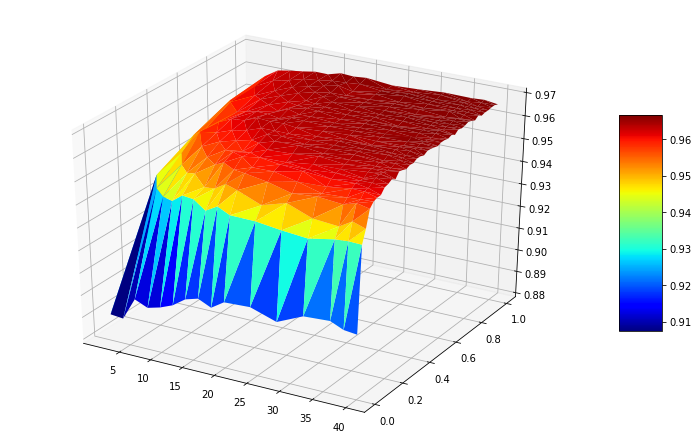

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(sftmx_contour_core["NumOfModels"], sftmx_contour_core["CNN%"], sftmx_contour_core["Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.88, 0.97)

plt.show()


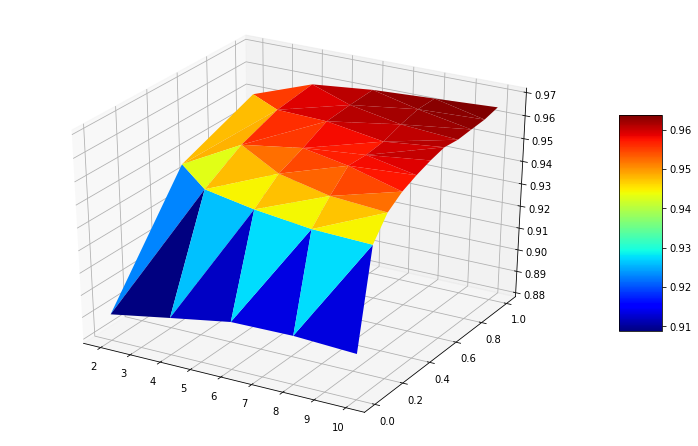

In [ ]:
plt.rcParams["figure.figsize"]=(10, 6)
fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(sftmx_contour_core.loc[sftmx_contour_core.NumOfModels<=10,"NumOfModels"], sftmx_contour_core.loc[sftmx_contour_core.NumOfModels<=10,"CNN%"], sftmx_contour_core.loc[sftmx_contour_core.NumOfModels<=10,"Acc"], cmap=cm.jet, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_zlim(0.88, 0.97)

plt.show()

In [ ]:
fig = go.Figure(data =
    go.Contour(
        z=sftmx_contour_core.Acc,
        x=sftmx_contour_core["NumOfModels"], # horizontal axis
        y=sftmx_contour_core["CNN%"], # vertical axis
    colorscale='RdBu',
    contours=dict(
            start=0.89,
            end=0.975,
            size=0.0025,
        )))

fig.update_layout(
    autosize=False,
    width=700,
    height=700,
    margin=dict(        l=50,        r=50,        b=100,        t=100,        pad=4    ),
    paper_bgcolor="White",
   title="Softmax Collaborative Test Accuracy using CNN+DNN ",
    xaxis_title="Total Number of Models",
    yaxis_title="% of CNN models"
)

fig.show()
